# A network-based method to harmonize data classifications
## SCIAN-CIIU-NAICS

In [1]:
## Cargamos paquetes 
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from py2cytoscape import util as cy 
from py2cytoscape import cytoscapejs as cyjs
import requests
import json
from IPython.display import Image
from IPython.display import Markdown as md
import os 

<IPython.core.display.Javascript object>

In [91]:
## Definimos rutas donde se encuentran las correspondencias scian-ciiu
FILE_PATH = os.getcwd()
DATA_PATH = os.path.join(FILE_PATH, "data")
OUTPUT_PATH = os.path.join(FILE_PATH, "output")
CW_ONET_SINCO_FILE_PATH = os.path.join(DATA_PATH, "sinco-onet.xlsx")
PAPER_AUTOMATIZACION_FILE_PATH = os.path.join(DATA_PATH, "frey2016.pdf")

In [90]:
## Cargamos el cw
cw_sinco_onet = pd.read_excel(CW_ONET_SINCO_FILE_PATH)
cw_sinco_onet

,soccode8dig,onetsoccode,title,soc2,cve_broad,soccode,soctitle,clave,sinco,nombre_sinco,soc,nombre_soc
0,11000000,11-1011.03,Chief Sustainability Officers,111010,11-1010,11-1011,Chief Executives,1,1111,Altas autoridades gubernamentales y jurisdicci...,11 1010,Ejecutivos en jefe
1,11000000,11-1011.00,Chief Executives,111010,11-1010,11-1011,Chief Executives,1,1111,Altas autoridades gubernamentales y jurisdicci...,11 1010,Ejecutivos en jefe
2,11000000,11-1031.00,Legislators,111030,11-1030,11-1031,Legislators,1,1111,Altas autoridades gubernamentales y jurisdicci...,11 1030,Legisladores
3,11000000,11-1031.00,Legislators,111030,11-1030,11-1031,Legislators,1,1112,Legisladores,11 1030,Legisladores
4,11000000,11-1011.03,Chief Sustainability Officers,111010,11-1010,11-1011,Chief Executives,1,1113,Presidentes y autoridades municipales,11 1010,Ejecutivos en jefe
...,...,...,...,...,...,...,...,...,...,...,...,...
2338,55000000,43-5021.00,Couriers and Messengers,435020,43-5020,43-5021,Couriers and Messengers,397,9722,Repartidores de mensajería (a pie y en bicicle...,43 5020,Mensajeros y repartidores
2339,55000000,43-5021.00,Couriers and Messengers,435020,43-5020,43-5021,Couriers and Messengers,397,9723,Repartidores de mercancías (a pie y en bicicleta),43 5020,Mensajeros y repartidores
2340,55000000,43-5041.00,"Meter Readers, Utilities",435040,43-5040,43-5041,"Meter Readers, Utilities",398,9731,Lecturistas de medidores,43 5040,Lectores de medidores de servicios públicos
2341,55000000,41-2012.00,Gaming Change Persons and Booth Cashiers,412010,41-2010,41-2012,Gambling Change Persons and Booth Cashiers,399,9732,Recolectores de dinero,41 2010,Cajeros


In [4]:
## Nos quedamos con las columnas soccode, soctitle, sinco, nombre_sinco
cw_sinco_onet = cw_sinco_onet[["onetsoccode", "sinco"]]
cw_sinco_onet

,onetsoccode,sinco
0,11-1011.03,1111
1,11-1011.00,1111
2,11-1031.00,1111
3,11-1031.00,1112
4,11-1011.03,1113
...,...,...
2338,43-5021.00,9722
2339,43-5021.00,9723
2340,43-5041.00,9731
2341,41-2012.00,9732


In [5]:
### Nos quedamos con los valores del codigo onetsoc anteriores al punto
cw_sinco_onet.onetsoccode = cw_sinco_onet.onetsoccode.apply(lambda x : x.split(".")[0])

/tmp/ipykernel_31417/1031606321.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cw_sinco_onet.onetsoccode = cw_sinco_onet.onetsoccode.apply(lambda x : x.split(".")[0])


In [6]:
### Generamos un re etiquetamiento para indizar los códigos onet a enteros

indice_to_onet = {i+1 : j for i,j in enumerate(cw_sinco_onet.onetsoccode.unique())}
onet_to_indice = {j : i+1  for i,j in enumerate(cw_sinco_onet.onetsoccode.unique())}
cw_sinco_onet["onetsoccode"] = cw_sinco_onet["onetsoccode"].replace(onet_to_indice)
cw_sinco_onet

/tmp/ipykernel_31417/1111779289.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cw_sinco_onet["onetsoccode"] = cw_sinco_onet["onetsoccode"].replace(onet_to_indice)


,onetsoccode,sinco
0,1,1111
1,1,1111
2,2,1111
3,2,1112
4,1,1113
...,...,...
2338,745,9722
2339,745,9723
2340,749,9731
2341,437,9732


In [7]:
indice_to_onet

{1: '11-1011',
 2: '11-1031',
 3: '11-1021',
 4: '11-9141',
 5: '21-2021',
 6: '11-2011',
 7: '11-3061',
 8: '11-3071',
 9: '11-3111',
 10: '11-3121',
 11: '11-3031',
 12: '11-9111',
 13: '11-9161',
 14: '11-9199',
 15: '11-9151',
 16: '11-3131',
 17: '11-9039',
 18: '11-9031',
 19: '11-9032',
 20: '11-9033',
 21: '23-1022',
 22: '23-1023',
 23: '23-1021',
 24: '55-1013',
 25: '55-1014',
 26: '55-1017',
 27: '55-1015',
 28: '55-1012',
 29: '55-1011',
 30: '55-1019',
 31: '55-1016',
 32: '11-9013',
 33: '11-3051',
 34: '11-9021',
 35: '11-9041',
 36: '11-3021',
 37: '11-9121',
 38: '11-2022',
 39: '11-2021',
 40: '11-9051',
 41: '11-9081',
 42: '27-2012',
 43: '27-2011',
 44: '25-4012',
 45: '25-4013',
 46: '25-4011',
 47: '11-9071',
 48: '33-1012',
 49: '33-1011',
 50: '33-1099',
 51: '45-1011',
 52: '47-1011',
 53: '51-1011',
 54: '49-1011',
 55: '39-9041',
 56: '13-1011',
 57: '39-4031',
 58: '11-9131',
 59: '13-1022',
 60: '13-1023',
 61: '13-1021',
 62: '13-1071',
 63: '13-1075',
 

## ONET-SINCO

In [8]:
"""
generate graph/network here
"""

# empty graph/network
G_onet_sinco = nx.Graph()
  

# add edges    
for k in cw_sinco_onet.index:
    i = tuple(cw_sinco_onet.iloc[[k]]["onetsoccode"].values)[0] 
    j = tuple(cw_sinco_onet.iloc[[k]]["sinco"].values)[0] 
    G_onet_sinco.add_edge(int(i),int(j)) 


In [9]:
def basic_stats(G):
    print("nodes: %d" % G.number_of_nodes())
    print("edges: %d" % G.number_of_edges())

In [10]:
basic_stats(G_onet_sinco)

nodes: 1180
edges: 1646


In [11]:
set_i = cw_sinco_onet[['onetsoccode']]
set_i = set_i.drop_duplicates(keep='first')
set_i['set_type']=int(1)
set_j = cw_sinco_onet[['sinco']]
set_j = set_j.drop_duplicates(keep='first')
set_j['set_type']=int(2)


set_i.onetsoccode = set_i.onetsoccode.astype(int)
set_i

set_j.sinco = set_j.sinco.astype(int)
set_j


# node attributes
node_type = set_i.set_index("onetsoccode").set_type.to_dict()
node_type.update(set_j.set_index("sinco").set_type.to_dict() )
for k in node_type:
    node_type[k]=int(node_type[k])

# assign attributes to networkx G
nx.set_node_attributes(G_onet_sinco,node_type,"n_type")




In [12]:
# move network from networkx to cy
G_onet_sinco.node = G_onet_sinco.nodes
cytoscape_network = cy.from_networkx(G_onet_sinco)

In [13]:
# Basic Setup
PORT_NUMBER = 1234
IP = 'localhost'
BASE = 'http://' + IP + ':' + str(PORT_NUMBER) + '/v1/'
HEADERS = {'Content-Type': 'application/json'}
requests.delete(BASE + 'session')

<Response [200]>

In [14]:
res1 = requests.post(BASE + 'networks', data=json.dumps(cytoscape_network), headers=HEADERS)
res1_dict = res1.json()
new_suid = res1_dict['networkSUID']
requests.get(BASE + 'apply/layouts/force-directed/' + str(new_suid))

<Response [200]>

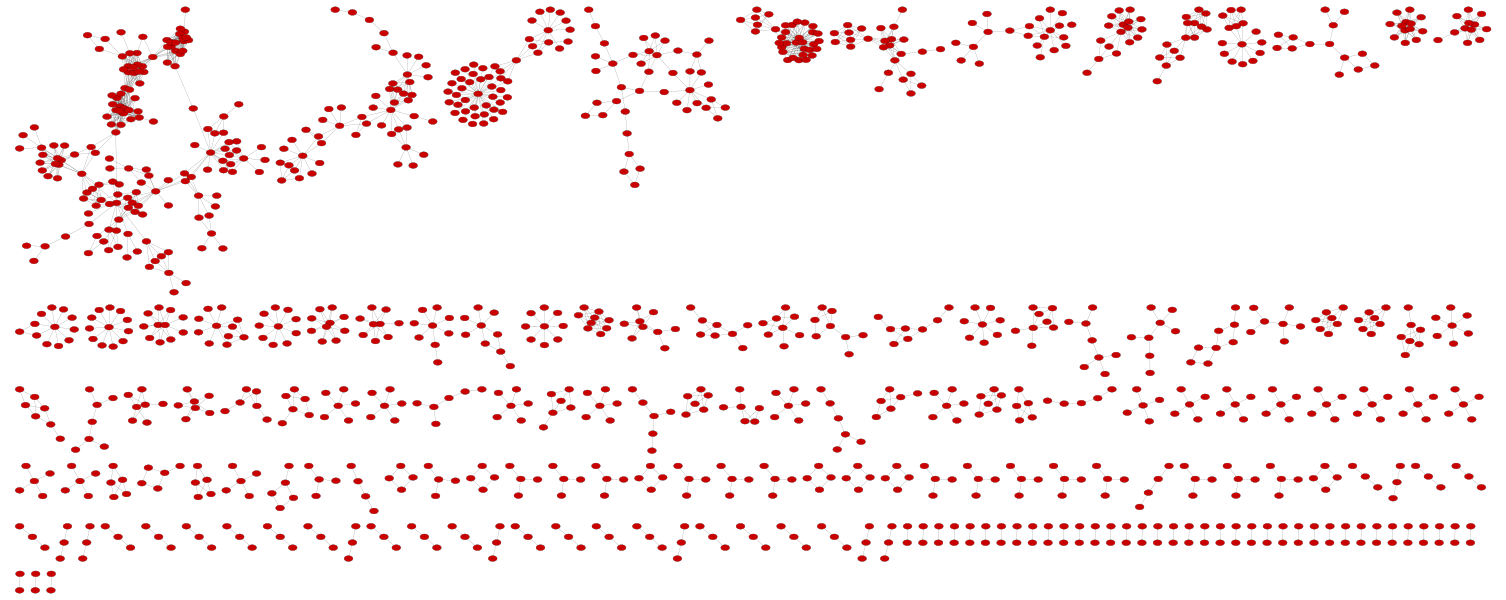

In [15]:
style_name = 'Basic_Style'

my_style = {
  "title" : style_name,
  "mappings" : [{
    "mappingType" : "discrete",
    "mappingColumn" : "n_type",
    "mappingColumnType" : "Double",
    "visualProperty" : "NODE_FILL_COLOR",
       "map" : [ {
      "key" : "1",
      "value" : "#CC0000"
    }, {
      "key" : "2",
      "value" : "#009999"
    }]  
  }], 
   'defaults': [{
       'visualProperty': 'EDGE_TRANSPARENCY', 
       'value': 255
  }, {
    "visualProperty" : "NODE_SIZE",
    'value': 20
  }, {
    "visualProperty" : "EDGE_WIDTH",
    'value': 1
  },{
       'visualProperty': 'NODE_LABEL_FONT_SIZE', 
       'value': 12
   },{
       'visualProperty': 'NODE_LABEL_TRANSPARENCY', 
       'value': 250
   }, {
       'visualProperty': 'NODE_TRANSPARENCY', 
       'value': 250
   }]
}

# Create new Visual Style
res = requests.post(BASE + "styles", data=json.dumps(my_style), headers=HEADERS)
new_style_name = res.json()['title']

# Apply it to current netwrok
requests.get(BASE + 'apply/styles/' + new_style_name + '/' + str(new_suid))

# Display
Image(BASE+'networks/' + str(new_suid) + '/views/first.png')

## 4 Main methodology  

### 4.1 An error-free solution to the many-to-many problem

The principle behind the method is rather simple: we are going to define a new, fictional, target classification, for each of the connected components in the network.

In [16]:
nc = nx.number_connected_components(G_onet_sinco)
nc


170

The new classification will have 151 industry classes. Each of the CIIU and each of the  SCIAN 2018 will converge towards one (and one only) of these 151 new classes.

With CIIU denoted with $i$, SCIAN 2018 with $j$, and the new classification with $k$. The concordance function is in this case
 

\begin{equation}
f^{CC}\left(\mathbf{C}_{ij}\right) = \left[
\begin{array}{c}
T_{ik} \\
T_{jk}
\end{array}
\right]
\end{equation}


That is, in this case, the concordance function (CC for connected components) has two outputs: one transformation matrix for $i$ and one for $j$. In practical terms we need to identify which of the CIIU and SCIAN belong to which component. The following code does that, returning the two transformation matrices $T_{ik}$ and $T_{jk}$

## 6 The complex case in a many-to-many mapping
### 6.1 When the network has a large connected component 

Let's consider a case where the concordance network has one large connected component. It may not be the only component, but let us say that it dominates the network significantly. In this case the method outlined this far is not suited to harmonize the classifications, as we would only have one (or very few) final classification.

We can however apply a modification of this method -- still based on network analysis -- that can provide an elegant solution, even though it is not error free.

The core idea behind the modified method is to identify the clusters (communities, more precisely) in the concordance network, and assign a new "target" classification to each of the clusters.

While a handful of components are small isolates, the majority of the concordance network is made of one large component, which is kept together only by few bridging nodes.

One solution is to use Cytoscape to identify this bridges and disconnect the components by hand. A quicker way to obtain the same result is to run a community discovery algorithm.

In this example I use 'label propagation' algorithm, but several options are possible.

In [17]:
from networkx.algorithms import community

In [18]:
C2 = community.label_propagation_communities(G_onet_sinco)

In [19]:
list_comp2=sorted(C2, key = len, reverse=True)
nc2 = len(list_comp2)
nc2

238

In [20]:
list_comp2

[{176,
  177,
  178,
  179,
  180,
  181,
  182,
  183,
  184,
  185,
  186,
  187,
  188,
  189,
  190,
  191,
  192,
  193,
  194,
  195,
  196,
  197,
  198,
  199,
  200,
  201,
  202,
  203,
  204,
  205,
  206,
  207,
  208,
  209,
  210,
  211,
  212,
  2321,
  2715},
 {546,
  547,
  548,
  549,
  550,
  6111,
  6112,
  6113,
  6114,
  6115,
  6116,
  6117,
  6119,
  6121,
  6122,
  6123,
  6124,
  6125,
  6126,
  6127,
  6131,
  6212,
  6223,
  6311,
  6999,
  9111,
  9112,
  9113},
 {604,
  605,
  606,
  642,
  643,
  644,
  645,
  646,
  647,
  648,
  670,
  674,
  682,
  683,
  7511,
  7512,
  7514,
  7515,
  7517,
  8133,
  8161,
  8162,
  8171,
  9236,
  9237,
  9239},
 {611,
  612,
  613,
  614,
  615,
  616,
  617,
  618,
  619,
  715,
  7321,
  7612,
  7613,
  7999,
  8143,
  8144,
  8999,
  9231,
  9232,
  9233,
  9234,
  9235},
 {293,
  294,
  295,
  296,
  297,
  298,
  299,
  300,
  303,
  2621,
  2623,
  2624,
  2631,
  2633,
  2635,
  2641,
  2643,
  2645},
 {344,

In [21]:
# final concordance tables generation
C123=pd.DataFrame(columns= ["code","code_3","s"])

i = 0
for c in range(nc2):
    code_3 =c+1 
    for n in list_comp2[c]:
        C123.loc[i] = 0
        C123.loc[i]["code"] = n
        C123.loc[i]["code_3"] = code_3        
        C123.loc[i]["s"] = np.floor(n / (10**(6) ) )  
        i += 1



In [22]:
C123

,code,code_3,s
0,2321,1,0
1,2715,1,0
2,176,1,0
3,177,1,0
4,178,1,0
...,...,...,...
1175,741,236,0
1176,742,237,0
1177,9663,237,0
1178,9731,238,0


In [23]:
C123["s"] = 1
C123.loc[C123.code.apply(lambda x: len(str(x))==4 ), "s"] = 2
C123

,code,code_3,s
0,2321,1,2
1,2715,1,2
2,176,1,1
3,177,1,1
4,178,1,1
...,...,...,...
1175,741,236,1
1176,742,237,1
1177,9663,237,2
1178,9731,238,2


In [24]:
T13=C123.loc[C123["s"]== 1] 
T23=C123.loc[C123["s"]== 2] 

T13.columns=["onetsoccode","new_code","s"]
T23.columns=["sinco","new_code","s"]


In [25]:
T13

,onetsoccode,new_code,s
2,176,1,1
3,177,1,1
4,178,1,1
5,179,1,1
6,180,1,1
...,...,...,...
1171,717,234,1
1172,728,235,1
1175,741,236,1
1176,742,237,1


In [26]:
T23

,sinco,new_code,s
0,2321,1,2
1,2715,1,2
39,9111,2,2
40,9112,2,2
41,9113,2,2
...,...,...,...
1170,9211,234,2
1173,9311,235,2
1174,9633,236,2
1177,9663,237,2


In [30]:
C123_exporta = C123.copy()
C123_exporta.columns = ["codigo", "codigo_nuevo", "clasificador"]
C123_exporta.loc[C123_exporta.clasificador==1,"clasificador"] = "onet"
C123_exporta.loc[C123_exporta.clasificador==2,"clasificador"] = "sinco"
C123_exporta["codigo"] = C123_exporta.codigo.replace(indice_to_onet)
C123_exporta

/tmp/ipykernel_31417/3736795187.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'onet' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  C123_exporta.loc[C123_exporta.clasificador==1,"clasificador"] = "onet"


,codigo,codigo_nuevo,clasificador
0,2321,1,sinco
1,2715,1,sinco
2,25-1011,1,onet
3,25-1022,1,onet
4,25-1021,1,onet
...,...,...,...
1175,53-6021,236,onet
1176,47-4041,237,onet
1177,9663,237,sinco
1178,9731,238,sinco


In [34]:
## Cargamos cw para agregar los nombres de las actividades
cw_sinco_onet_nombres = pd.read_excel(DATA_PATH)[["onetsoccode", "soctitle", "sinco", "nombre_sinco"]]
cw_sinco_onet_nombres.onetsoccode = cw_sinco_onet_nombres.onetsoccode.apply(lambda x : x.split(".")[0])
cw_sinco_onet_nombres

,onetsoccode,soctitle,sinco,nombre_sinco
0,11-1011,Chief Executives,1111,Altas autoridades gubernamentales y jurisdicci...
1,11-1011,Chief Executives,1111,Altas autoridades gubernamentales y jurisdicci...
2,11-1031,Legislators,1111,Altas autoridades gubernamentales y jurisdicci...
3,11-1031,Legislators,1112,Legisladores
4,11-1011,Chief Executives,1113,Presidentes y autoridades municipales
...,...,...,...,...
2338,43-5021,Couriers and Messengers,9722,Repartidores de mensajería (a pie y en bicicle...
2339,43-5021,Couriers and Messengers,9723,Repartidores de mercancías (a pie y en bicicleta)
2340,43-5041,"Meter Readers, Utilities",9731,Lecturistas de medidores
2341,41-2012,Gambling Change Persons and Booth Cashiers,9732,Recolectores de dinero


In [50]:
### Agregamos nombres de las actividades
C123_exporta["nombre_ocupacion"] = C123_exporta.codigo
C123_exporta["nombre_ocupacion"] = C123_exporta.nombre_ocupacion.replace({i:j for i,j in cw_sinco_onet_nombres[["onetsoccode", "soctitle"]].to_records(index = False)})
C123_exporta["nombre_ocupacion"] = C123_exporta.nombre_ocupacion.replace({i:j for i,j in cw_sinco_onet_nombres[["sinco", "nombre_sinco"]].to_records(index = False)})
C123_exporta.query("codigo_nuevo==80")

,codigo,codigo_nuevo,clasificador,nombre_ocupacion
714,43-4051,80,onet,Customer Service Representatives
715,43-4081,80,onet,"Hotel, Motel, and Resort Desk Clerks"
716,43-4171,80,onet,Receptionists and Information Clerks
717,43-4199,80,onet,"Information and Record Clerks, All Other"
718,3211,80,sinco,Recepcionistas y trabajadores que brindan info...


In [ ]:
C123_exporta.to_csv(os.path.join(OUTPUT_PATH, "recodificacion_ciiu-rev-4_scian_2018.csv") , index = False)

In [92]:
import tabula
# Read pdf into a list of DataFrame
dfs = tabula.read_pdf(PAPER_AUTOMATIZACION_FILE_PATH, pages='all')


Got stderr: Apr 10, 2025 5:47:35 PM org.apache.pdfbox.pdmodel.font.PDSimpleFont toUnicode
Apr 10, 2025 5:47:37 PM org.apache.pdfbox.pdmodel.font.PDSimpleFont toUnicode
Apr 10, 2025 5:47:37 PM org.apache.pdfbox.pdmodel.font.PDSimpleFont toUnicode
Apr 10, 2025 5:47:37 PM org.apache.pdfbox.pdmodel.font.PDSimpleFont toUnicode
Apr 10, 2025 5:47:37 PM org.apache.pdfbox.pdmodel.font.PDSimpleFont toUnicode
Apr 10, 2025 5:47:37 PM org.apache.pdfbox.pdmodel.font.PDSimpleFont toUnicode



In [93]:
df_prob_automatizacion = pd.concat([dfs[i].iloc[1:] for i in range(-11, -1)], ignore_index = True)
df_prob_automatizacion.columns = ["rank", "probability", "label", "onetsoccode", "occupation"]
df_prob_automatizacion

,rank,probability,label,onetsoccode,occupation
0,1.,0.0028,NaN,29-1125,Recreational therapists
1,2.,0.003,NaN,49-1011,"First-line supervisors of mechanics, installer..."
2,3.,0.003,NaN,11-9161,Emergency management directors
3,4.,0.0031,NaN,21-1023,Mental health and substance abuse social workers
4,5.,0.0033,NaN,29-1181,Audiologists
...,...,...,...,...,...
697,698.,0.99,1,13-2053,Insurance underwriters
698,699.,0.99,NaN,15-2091,Mathematical technicians
699,700.,0.99,NaN,51-6051,"Sewers, hand"
700,701.,0.99,NaN,23-2093,"Title examiners, abstractors, and searchers"


In [96]:
C123_exporta["probabilidad"] = C123_exporta.codigo.replace({i:j for i,j in df_prob_automatizacion[["onetsoccode", "probability"]].to_records(index = False)})

In [120]:
df_prob_automatizacion["onetsoccode_2d"] = df_prob_automatizacion["onetsoccode"].apply(lambda x : x[:5])

In [125]:
df_prob_automatizacion["probability"] = df_prob_automatizacion["probability"].astype(float)

In [132]:
probs_2d = {i:j for i,j in df_prob_automatizacion.groupby("onetsoccode_2d").agg({"probability" : "mean"}).reset_index().to_records(index=False) if not np.isnan(j)}

In [144]:
C123_exporta["probabilidad"] = C123_exporta["probabilidad"].apply(lambda x : probs_2d[x[:5]] if len(str(x))==7 and  x[:5] in probs_2d else x)

In [150]:
C123_exporta[C123_exporta["probabilidad"].apply(lambda x : "." not in str(x))].query("clasificador=='onet'")

,codigo,codigo_nuevo,clasificador,nombre_ocupacion,probabilidad,onetsoccode_2d
26,25-1113,1,onet,"Social Work Teachers, Postsecondary",25-1113,25-11
27,25-1112,1,onet,"Law Teachers, Postsecondary",25-1112,25-11
28,25-1111,1,onet,"Criminal Justice and Law Enforcement Teachers,...",25-1111,25-11
29,25-1125,1,onet,"History Teachers, Postsecondary",25-1125,25-11
30,25-1126,1,onet,"Philosophy and Religion Teachers, Postsecondary",25-1126,25-11
31,25-1121,1,onet,"Art, Drama, and Music Teachers, Postsecondary",25-1121,25-11
32,25-1123,1,onet,"English Language and Literature Teachers, Post...",25-1123,25-11
33,25-1124,1,onet,"Foreign Language and Literature Teachers, Post...",25-1124,25-11
34,25-1122,1,onet,"Communications Teachers, Postsecondary",25-1122,25-11
35,25-1199,1,onet,"Postsecondary Teachers, All Other",25-1199,25-11


In [156]:
onet_excluye = C123_exporta[C123_exporta["probabilidad"].apply(lambda x : "." not in str(x))].query("clasificador=='onet'").codigo


In [162]:
C123_exporta = C123_exporta[~C123_exporta.codigo.isin(onet_excluye)]
C123_exporta

,codigo,codigo_nuevo,clasificador,nombre_ocupacion,probabilidad,onetsoccode_2d
0,2321,1,sinco,Profesores universitarios y de enseñanza superior,2321,2321
1,2715,1,sinco,Instructores y capacitadores en oficios y para...,2715,2715
2,25-1011,1,onet,"Business Teachers, Postsecondary",0.032,25-10
3,25-1022,1,onet,"Mathematical Science Teachers, Postsecondary",0.032,25-10
4,25-1021,1,onet,"Computer Science Teachers, Postsecondary",0.032,25-10
...,...,...,...,...,...,...
1175,53-6021,236,onet,Parking Attendants,0.79,53-60
1176,47-4041,237,onet,Hazardous Materials Removal Workers,0.53,47-40
1177,9663,237,sinco,Recolectores de otros materiales,9663,9663
1178,9731,238,sinco,Lecturistas de medidores,9731,9731


# DATOS ONET (Abilities, Skills, Knowledge)

In [165]:
ONET_DATA_PATH = os.path.join(FILE_PATH, "data", "onet", "db_28_2_text")
SKILLS_ONET_DATA_PATH = os.path.join(ONET_DATA_PATH, "Skills.txt")
KNOWLEDGE_ONET_DATA_PATH = os.path.join(ONET_DATA_PATH, "Knowledge.txt")
ABILITIES_ONET_DATA_PATH = os.path.join(ONET_DATA_PATH, "Abilities.txt")

In [184]:
# Cargamos datos
skills = pd.read_table(SKILLS_ONET_DATA_PATH)
knowledge = pd.read_table(KNOWLEDGE_ONET_DATA_PATH)
abilities = pd.read_table(ABILITIES_ONET_DATA_PATH)

# Filtramos datos
skills = skills[(skills["Domain Source"]=="Analyst") & (skills["Scale ID"]=="IM")]
abilities = abilities[(abilities["Domain Source"]=="Analyst") & (abilities["Scale ID"]=="IM")]
knowledge = knowledge[(knowledge["Domain Source"]=="Incumbent") & (knowledge["Scale ID"]=="IM")]

In [190]:
# Agrupamos valores
skills["onet_code"] = skills["O*NET-SOC Code"].apply(lambda x : x.split(".")[0])
abilities["onet_code"] = abilities["O*NET-SOC Code"].apply(lambda x : x.split(".")[0])
knowledge["onet_code"] = knowledge["O*NET-SOC Code"].apply(lambda x : x.split(".")[0])


In [195]:
knowledge_grouped = knowledge.groupby(["onet_code", "Element ID"]).agg({"Data Value" : "mean"}).reset_index()
abilities_grouped = abilities.groupby(["onet_code", "Element ID"]).agg({"Data Value" : "mean"}).reset_index()
skills_grouped = skills.groupby(["onet_code", "Element ID"]).agg({"Data Value" : "mean"}).reset_index()

In [198]:
skills_grouped["element_id"] = skills_grouped["Element ID"]+"_skills" 
abilities_grouped["element_id"] = abilities_grouped["Element ID"]+"_abilities" 
knowledge_grouped["element_id"] = knowledge_grouped["Element ID"]+"_knowledge"

In [200]:
## Concatenamos los datos
features_occupations = pd.concat([skills_grouped, abilities_grouped, knowledge_grouped], ignore_index=True)
features_occupations

,onet_code,Element ID,Data Value,element_id
0,11-1011,2.A.1.a,4.060,2.A.1.a_skills
1,11-1011,2.A.1.b,4.000,2.A.1.b_skills
2,11-1011,2.A.1.c,4.120,2.A.1.c_skills
3,11-1011,2.A.1.d,4.125,2.A.1.d_skills
4,11-1011,2.A.1.e,3.065,2.A.1.e_skills
...,...,...,...,...
85576,53-7121,2.C.7.e,1.190,2.C.7.e_knowledge
85577,53-7121,2.C.8.a,3.150,2.C.8.a_knowledge
85578,53-7121,2.C.8.b,1.810,2.C.8.b_knowledge
85579,53-7121,2.C.9.a,2.130,2.C.9.a_knowledge


In [204]:
features_occupations = features_occupations[features_occupations.onet_code.isin(C123_exporta.codigo)]
features_occupations

,onet_code,Element ID,Data Value,element_id
0,11-1011,2.A.1.a,4.060,2.A.1.a_skills
1,11-1011,2.A.1.b,4.000,2.A.1.b_skills
2,11-1011,2.A.1.c,4.120,2.A.1.c_skills
3,11-1011,2.A.1.d,4.125,2.A.1.d_skills
4,11-1011,2.A.1.e,3.065,2.A.1.e_skills
...,...,...,...,...
85576,53-7121,2.C.7.e,1.190,2.C.7.e_knowledge
85577,53-7121,2.C.8.a,3.150,2.C.8.a_knowledge
85578,53-7121,2.C.8.b,1.810,2.C.8.b_knowledge
85579,53-7121,2.C.9.a,2.130,2.C.9.a_knowledge


In [208]:
### Calculamos la matriz de proximidad
from ecomplexity import ecomplexity
from ecomplexity import proximity

features_occupations["year"] = 2024

trade_cols = {'time':'year', 'loc':'element_id', 'prod':'onet_code', 'val':'Data Value'}
prox_df = proximity(features_occupations, trade_cols)
prox_df

2024


,year,onet_code_1,onet_code_2,proximity
1,2024,11-1011,11-1021,0.859375
2,2024,11-1011,11-2011,0.833333
3,2024,11-1011,11-2021,0.876923
4,2024,11-1011,11-2022,0.571429
5,2024,11-1011,11-3021,0.809524
...,...,...,...,...
413443,2024,53-7121,53-7064,0.610169
413444,2024,53-7121,53-7071,0.745098
413445,2024,53-7121,53-7072,0.732143
413446,2024,53-7121,53-7073,0.770833


In [253]:
## Creamos link si la proximidad es mayor a 0.8
prox_df_link = prox_df.query("proximity>0.65")

In [254]:
prox_df_link

,year,onet_code_1,onet_code_2,proximity
1,2024,11-1011,11-1021,0.859375
2,2024,11-1011,11-2011,0.833333
3,2024,11-1011,11-2021,0.876923
5,2024,11-1011,11-3021,0.809524
6,2024,11-1011,11-3031,0.830769
...,...,...,...,...
413442,2024,53-7121,53-7063,0.666667
413444,2024,53-7121,53-7071,0.745098
413445,2024,53-7121,53-7072,0.732143
413446,2024,53-7121,53-7073,0.770833


In [255]:
## Creamos la gráfica
import networkx as nx
G_onet = nx.from_pandas_edgelist(prox_df_link, "onet_code_1", "onet_code_2")
                         

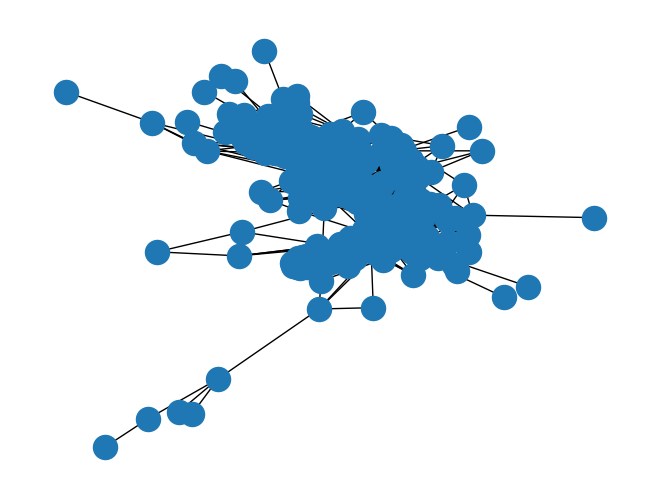

In [256]:
nx.draw(G_onet)

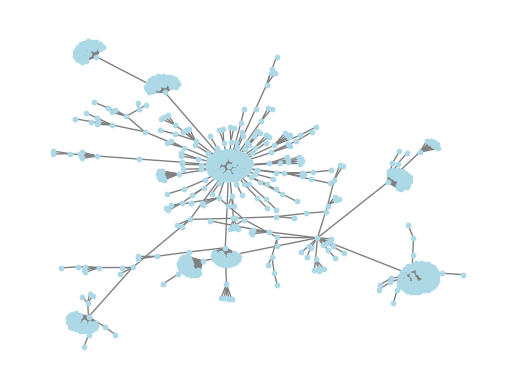

In [257]:
## MAXIMUM SPANNING TREE
# Find the minimum spanning tree
T = nx.minimum_spanning_tree(G_onet)

# Visualize the graph and the minimum spanning tree
pos = nx.spring_layout(T)
nx.draw_networkx_nodes(T, pos, node_color="lightblue", node_size=10)
nx.draw_networkx_edges(T, pos, edge_color="grey")
plt.axis("off")
plt.show()


# REPETIMOS EL EJERCICIO PERO CON LOS 238 GRUPOS

In [258]:
features_occupations

,onet_code,Element ID,Data Value,element_id,year
0,11-1011,2.A.1.a,4.060,2.A.1.a_skills,2024
1,11-1011,2.A.1.b,4.000,2.A.1.b_skills,2024
2,11-1011,2.A.1.c,4.120,2.A.1.c_skills,2024
3,11-1011,2.A.1.d,4.125,2.A.1.d_skills,2024
4,11-1011,2.A.1.e,3.065,2.A.1.e_skills,2024
...,...,...,...,...,...
85576,53-7121,2.C.7.e,1.190,2.C.7.e_knowledge,2024
85577,53-7121,2.C.8.a,3.150,2.C.8.a_knowledge,2024
85578,53-7121,2.C.8.b,1.810,2.C.8.b_knowledge,2024
85579,53-7121,2.C.9.a,2.130,2.C.9.a_knowledge,2024


In [266]:
features_occupations["onet_code_reclasificado"] = features_occupations["onet_code"].replace({i:j for i,j in C123_exporta.query("clasificador=='onet'")[["codigo", "codigo_nuevo"]].to_records(index = False)})

In [270]:
features_occupations_recod =features_occupations.groupby(["onet_code_reclasificado", "element_id"]).agg({"Data Value" : "mean"}).reset_index()
features_occupations_recod

,onet_code_reclasificado,element_id,Data Value
0,1,1.A.1.a.1_abilities,4.052609
1,1,1.A.1.a.2_abilities,4.084783
2,1,1.A.1.a.3_abilities,4.373913
3,1,1.A.1.a.4_abilities,4.036522
4,1,1.A.1.b.1_abilities,3.161304
...,...,...,...
25615,238,2.C.7.e_knowledge,1.180000
25616,238,2.C.8.a_knowledge,3.470000
25617,238,2.C.8.b_knowledge,2.190000
25618,238,2.C.9.a_knowledge,2.090000


In [272]:
features_occupations_recod["year"] = 2024
trade_cols = {'time':'year', 'loc':'element_id', 'prod':'onet_code_reclasificado', 'val':'Data Value'}
prox_df_recod = proximity(features_occupations_recod, trade_cols)
prox_df_recod

2024


,year,onet_code_reclasificado_1,onet_code_reclasificado_2,proximity
1,2024,1,2,0.216667
2,2024,1,3,0.133333
3,2024,1,4,0.133333
4,2024,1,5,0.350000
5,2024,1,6,0.166667
...,...,...,...,...
47955,2024,238,232,0.740741
47956,2024,238,233,0.685185
47957,2024,238,235,0.534483
47958,2024,238,236,0.648148


In [314]:
## Creamos link si la proximidad es mayor a 0.5
prox_df_link_recod = prox_df_recod.query("proximity>0.6")
prox_df_link_recod

,year,onet_code_reclasificado_1,onet_code_reclasificado_2,proximity
9,2024,1,10,0.650000
10,2024,1,11,0.700000
19,2024,1,22,0.750000
20,2024,1,23,0.733333
22,2024,1,25,0.833333
...,...,...,...,...
47954,2024,238,231,0.740741
47955,2024,238,232,0.740741
47956,2024,238,233,0.685185
47958,2024,238,236,0.648148


In [315]:
## Creamos la gráfica
G_onet_recod = nx.from_pandas_edgelist(prox_df_link_recod, "onet_code_reclasificado_1", "onet_code_reclasificado_2")

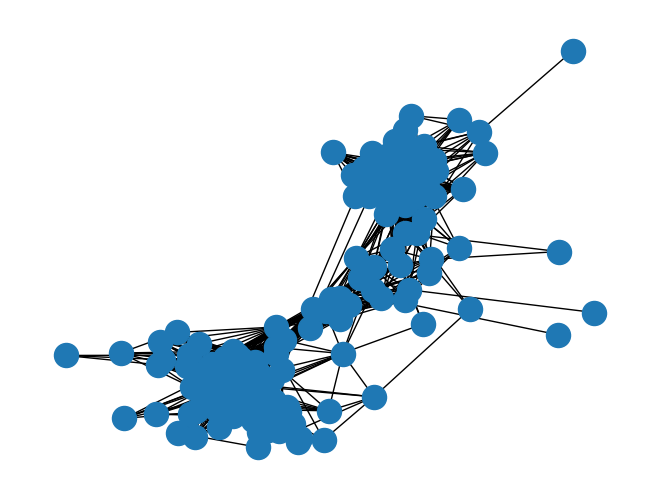

In [316]:
nx.draw(G_onet_recod)

In [317]:
len(G_onet_recod.nodes)

216

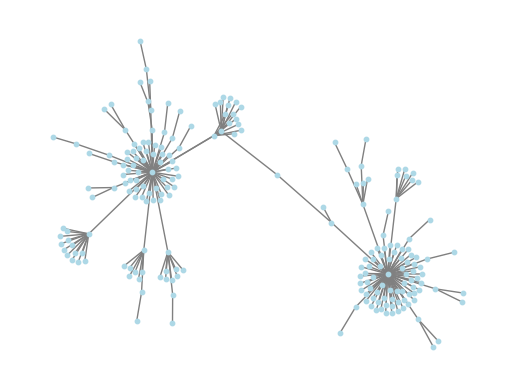

In [318]:
## MAXIMUM SPANNING TREE
# Find the minimum spanning tree
T = nx.minimum_spanning_tree(G_onet_recod)

# Visualize the graph and the minimum spanning tree
pos = nx.spring_layout(T)
nx.draw_networkx_nodes(T, pos, node_color="lightblue", node_size=10)
nx.draw_networkx_edges(T, pos, edge_color="grey")
plt.axis("off")
plt.show()